# Fitting a simple model: Logistic growth

We have created a dataset in the previous notebook, now it is time to use some data to fit a model. <br>
A complete definition of a fitting problem consists of 

1. Data 
2. Parameters
3. Simulation
4. A fitting routine (calibration algorithm + additional analysis steps)

In the subdirectory `logistic_growth`, we have an example of how these ingredients can be arranged into Python scripts. 

You could use this as a template for other fitting problems. 

In [1]:
%load_ext autoreload
%autoreload 2
from logistic_growth.fitting_problem import prob

C:\Users\hansul\projects\mempy_packages\memypfit\mempyfit\mempyfit\dataset.py:86: UserWarning: No temperature given for t-OD and no temperature found in labels.
  warnings.warn(f"No temperature given for {name} and no temperature found in labels.")


With `logistic_growth` loaded, we can execute the calibration:

In [2]:
#prob.solve()

## Defining the data

We can have a quick look at the data using the `plot` function. 
What we are looking at are optical density values from an experiment with *Batrachochytrium dendrobaditis* ([Voyles et al., 2017](https://link.springer.com/article/10.1007/s00442-017-3866-8)).

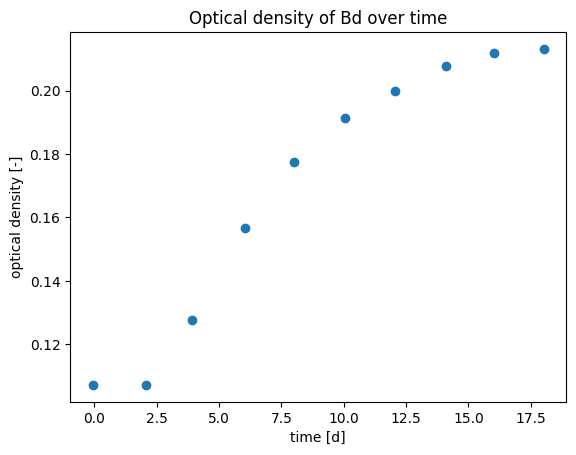

In [3]:
fig, ax = prob.data.plot('t-OD')

## Defining the parameters

## Defining the simulator

Below we have a small test to check that our loss function behaves as expected when we change just a single parameter.  

We should see a U-shaped curve that hits a minimum a little above 0.2, which is where we have the maximum observed density in the data. <br>
Note that we haven't explicitly defined an error model for the data (this would be done in the `data.add()` statements). In that case, `mempyfit` takes the sum of squares as default.

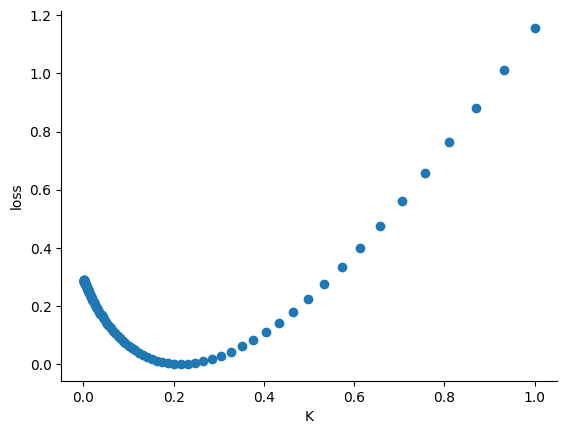

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# this updates the loss function attached to our prob object, 
# making sure that it uses all data that we had entered

prob.define_loss() 

Kvals = np.geomspace(1e-3, 1, 100)
lvals = []

for K in Kvals:
    prob.parameters['K'] = K
    sim = prob.simulator(prob.parameters)
    loss = prob.loss(sim, prob.data)
    lvals.append(loss)

fig = plt.figure(); ax = fig.gca()
ax.scatter(Kvals, lvals)
ax.set(xlabel = 'K', ylabel = 'loss')
sns.despine()

## Running the etimation

In [5]:
from mempyfit import *

In [6]:
local_optim = ScipyBackend(prob)
local_optim.run()

Fitted model using Nelder-Mead method.


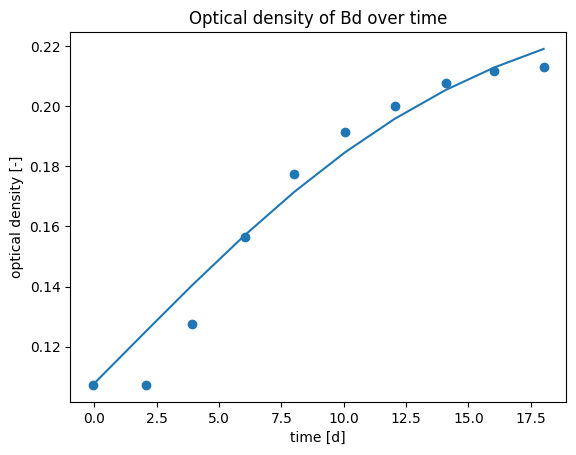

In [ ]:
fit = local_optim.get_fitted_sim()

fig, ax = prob.data.plot('t-OD')
fit.plot('t-OD', ax = ax, kind = "simulation")

## Running the estimation

Now we are ready to perform the actual parameter inference. 
To do so, we will first use the well-known [Nelder-Mead](https://link.springer.com/article/10.1007/s00442-017-3866-8) algorithm, a local optimization methd.

In [ ]:
prob.run(method = NelderMead())